In [1]:
from matplotlib import pyplot as plt
from Function import *
from utils_Optimizer import *

In [2]:
root = r"..\data\CarTruck"
train_x_orig, train_y = load_data(root=root, set_type="train")
valid_x_orig, valid_y = load_data(root=root, set_type="valid")
test_x_orig, test_y = load_data(root=root, set_type="test")

In [3]:
print(train_x_orig.shape)
print(train_y.shape)

(977, 64, 64, 3)
(1, 977)


1


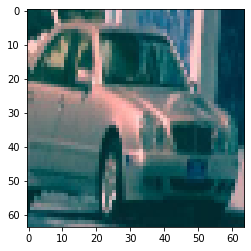

In [4]:
i = 0
print(train_y[i][0])
plt.imshow(train_x_orig[i])

In [5]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
valid_x_flatten = valid_x_orig.reshape(valid_x_orig.shape[0], -1).T   
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255
valid_x = valid_x_flatten/255
test_x = test_x_flatten/255

print ("train_x's shape: " + str(train_x.shape))
print ("valid_x's shape: " + str(valid_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 977)
valid_x's shape: (12288, 194)
test_x's shape: (12288, 96)


In [6]:
layers_dims = [train_x.shape[0], 128, 32, 8, 1] 
keep_probs = [0.7, 0.8, 0.87, 0.9]

In [7]:
def L_layer_model(X_train, Y_train, X_valid, Y_valid, 
                  layers_dims, 
                  lambd=0.7, 
                  drop_out=True, 
                  keep_probs=keep_probs, 
                  learning_rate = 0.0075, 
                  mini_batch_size=64, 
                  beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, 
                  num_iterations = 3000, 
                  print_cost=False):

    costs_train = []       
    costs_valid = []                 
    t = 0
    parameters = initialize_parameters_deep(layers_dims)
    
    v, s = initialize_adam(parameters)
 
    for i in range(0, num_iterations):
        
        minibatches_train = random_mini_batches(X_train, Y_train, mini_batch_size)
        for minibatch in minibatches_train:
            
            (minibatch_X, minibatch_Y) = minibatch

            AL_train, caches = L_model_forward(minibatch_X, parameters, keep_probs=keep_probs, drop_out=drop_out)
            cost_train = compute_cost(AL_train, minibatch_Y, parameters, lambd)
            
            AL_valid, _ = L_model_forward(X_valid, parameters, keep_probs=keep_probs, drop_out=False)
            cost_valid = compute_cost(AL_valid, Y_valid, parameters, lambd)

            grads = L_model_backward(AL_train, Y_train, caches, lambd, drop_out=drop_out)

            t = t + 1 # Adam counter
            parameters, v, s = update_parameters_with_adam(parameters, 
                                                           grads, 
                                                           v, s,
                                                           t, 
                                                           learning_rate, 
                                                           beta1, beta2, epsilon)

        if print_cost and i % 100 == 0:
            print ("Train_cost after iteration %i: %f" %(i, cost_train))
            print ("Valid_cost after iteration %i: %f" %(i, cost_valid))
        if print_cost and i % 100 == 0:
            costs_train.append(cost_train)
            costs_valid.append(cost_valid)
            
    plt.plot(np.squeeze(costs_train), color='blue', label='Train_cost')
    plt.plot(np.squeeze(costs_valid), color='orange', label='Val_cost')
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.legend(loc='lower left', shadow=True)
    plt.show()
    
    return parameters

Train_cost after iteration 0: 0.767740
Valid_cost after iteration 0: 1.008745
Train_cost after iteration 100: 0.737355
Valid_cost after iteration 100: 0.975022


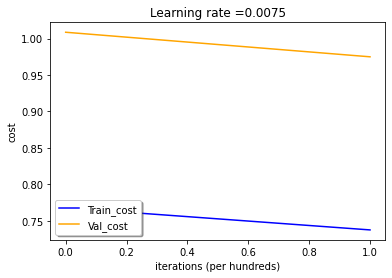

In [8]:
parameters = L_layer_model(train_x, train_y, valid_x, valid_y, 
                           layers_dims, 
                           lambd=0.7, 
                           drop_out=True, 
                           keep_probs=keep_probs, 
                           num_iterations = 200, 
                           print_cost = True)